<a href="https://colab.research.google.com/github/emrapport/w266-final-project/blob/master/final_model_save_dev_test_probs_preds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# name of subfolder under models/ where trained models should go
MODEL_PREFIX = "test"

hyp_combos = [{'ARCHITECTURE': 'JOHNSON',
                'NUM_EPOCHS': 20,
                'BATCH_SIZE': 10000,
                'MAX_SEQUENCE_LENGTH': 40,
                'N_MOST_FREQ_WORDS_TO_KEEP': 5000,
                'MAX_RESPONSES_PER_POST': 50,
                # a block is a set of two conv layers and a max pooling layer
                # max pooling layers currently always have size 3 stride 2 like in paper
                # we could paramaterize that if we want 
                'NUM_BLOCKS': 3,
                'CONV_LAYER_SIZE': 128,
                'FILTER_SIZE': 3,
                'DROPOUT_RATE': .2,
                # embed dim needs to map to one of the glove versions: 50, 100, 200, 300 
                'EMBEDDING_DIM': 50,
                'REMOVE_SHORT_RESP_LENGTH':1,
                'SAMPLE_FROM_BEG_AND_END':True}               
                ]

In [2]:
# examples of all the hyp dicts for each arch
{'ARCHITECTURE': 'BYO',
                    'NUM_EPOCHS': 1,
                'BATCH_SIZE': 1000,
                'MAX_SEQUENCE_LENGTH': 20,
                'N_MOST_FREQ_WORDS_TO_KEEP': 5000,
                'MAX_RESPONSES_PER_POST': 50,
                'NUM_LAYERS': 2,
                'CONV_LAYER_SIZES': [128, 128],
                'FILTER_SIZES': [4, 4],
                'DROPOUT_RATES': [.2, .2],
                'FINAL_DENSE_LAYER_SIZE': 10,
                # embed dim needs to map to one of the glove versions: 50, 100, 200, 300 
                'EMBEDDING_DIM': 50,
                'REMOVE_SHORT_RESP_LENGTH':1,
                'SAMPLE_FROM_BEG_AND_END':True},
{'ARCHITECTURE': 'JOHNSON',
                 'NUM_EPOCHS': 10,
                'BATCH_SIZE': 1000,
                'MAX_SEQUENCE_LENGTH': 20,
                'N_MOST_FREQ_WORDS_TO_KEEP': 5000,
                'MAX_RESPONSES_PER_POST': 50,
                # a block is a set of two conv layers and a max pooling layer
                # max pooling layers currently always have size 3 stride 2 like in paper
                # we could paramaterize that if we want 
                'NUM_BLOCKS': 15,
                'CONV_LAYER_SIZE': 128,
                'FILTER_SIZE': 3,
                'DROPOUT_RATE': .5,
                # embed dim needs to map to one of the glove versions: 50, 100, 200, 300 
                'EMBEDDING_DIM': 50,
                'REMOVE_SHORT_RESP_LENGTH':1,
                'SAMPLE_FROM_BEG_AND_END':True}, 
{'ARCHITECTURE': 'KIM',
                'NUM_EPOCHS': 10,
                'BATCH_SIZE': 1000,
                'MAX_SEQUENCE_LENGTH': 20,
                'N_MOST_FREQ_WORDS_TO_KEEP': 5000,
                'MAX_RESPONSES_PER_POST': 50,
                 # the true conv layer size is the 
                 # conv_layer_size multiplied by length of filter sizes
                'CONV_LAYER_SIZE': 64,
                'FILTER_SIZES': [2, 4, 6],
                'DROPOUT_RATE': .2,
                # embed dim needs to map to one of the glove versions: 50, 100, 200, 300 
                'EMBEDDING_DIM': 50,
                'REMOVE_SHORT_RESP_LENGTH':1,
                'SAMPLE_FROM_BEG_AND_END':True},

({'ARCHITECTURE': 'KIM',
  'BATCH_SIZE': 1000,
  'CONV_LAYER_SIZE': 64,
  'DROPOUT_RATE': 0.2,
  'EMBEDDING_DIM': 50,
  'FILTER_SIZES': [2, 4, 6],
  'MAX_RESPONSES_PER_POST': 50,
  'MAX_SEQUENCE_LENGTH': 20,
  'NUM_EPOCHS': 10,
  'N_MOST_FREQ_WORDS_TO_KEEP': 5000,
  'REMOVE_SHORT_RESP_LENGTH': 1,
  'SAMPLE_FROM_BEG_AND_END': True},)

In [3]:
## check to ensure hyps are in agreement
for i,hyp_combo in enumerate(hyp_combos):
  assert hyp_combo['ARCHITECTURE'] in ['BYO', 'KIM', 'JOHNSON']
  if hyp_combo['ARCHITECTURE'] == 'BYO':
    assert hyp_combo['NUM_LAYERS'] == len(hyp_combo['CONV_LAYER_SIZES'])
    assert hyp_combo['NUM_LAYERS'] == len(hyp_combo['FILTER_SIZES'])
    assert hyp_combo['NUM_LAYERS'] == len(hyp_combo['DROPOUT_RATES'])
  if hyp_combo['ARCHITECTURE'] == 'KIM':
    assert type(hyp_combo['CONV_LAYER_SIZE'])==int
    assert type(hyp_combo['FILTER_SIZES'])==list
    assert type(hyp_combo['DROPOUT_RATE'])==float
  if hyp_combo['ARCHITECTURE'] == 'JOHNSON':
    assert type(hyp_combo['NUM_BLOCKS'])==int
    assert type(hyp_combo['CONV_LAYER_SIZE'])==int
    assert type(hyp_combo['FILTER_SIZE'])==int
    assert type(hyp_combo['DROPOUT_RATE'])==float
  print("Model {} passed".format(i))

Model 0 passed


In [4]:
## all this stuff just needs to get run one time per notebook
# Set seeds for reproducible results.
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve, auc
from keras.preprocessing.sequence import pad_sequences
from scipy.sparse import hstack, vstack
from keras.preprocessing.text import Tokenizer
from keras import Sequential, layers
from keras.utils import plot_model
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import time
import pickle
!pip install gcsfs

pd.set_option('max_colwidth', 100)

project_id = 'w266-251323'
import uuid
bucket_name = 'fb-congressional-data/'
from google.colab import auth
auth.authenticate_user()
!gcloud config set project {project_id}


Using TensorFlow backend.


Updated property [core/project].


In [5]:
train_df = pd.read_csv("gs://fb-congressional-data/contraction_expanded_data/train.csv", index_col=0)
dev_df = pd.read_csv("gs://fb-congressional-data/contraction_expanded_data/dev.csv", index_col=0)
test_df = pd.read_csv("gs://fb-congressional-data/contraction_expanded_data/test.csv", index_col=0)
!gsutil cp gs://fb-congressional-data/glove* /tmp/

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Copying gs://fb-congressional-data/glove.6B.100d.txt...
Copying gs://fb-congressional-data/glove.6B.200d.txt...
Copying gs://fb-congressional-data/glove.6B.300d.txt...
Copying gs://fb-congressional-data/glove.6B.50d.txt...
\ [4 files][  2.1 GiB/  2.1 GiB]  142.9 MiB/s                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://fb-congressional-data/glove.6B.zip...
/ [5 files][  2.9 GiB/  2.9 GiB]  136.3 MiB/s                                   
Operation completed over 5 objects/2.9 GiB.                                      


In [0]:
# all the functions go here
def remove_excess_rows_per_post(df, max_per_post):
  num_responses_per_post = df.post_id.value_counts().reset_index()
  num_responses_per_post.columns = ['post_id', 'num_responses']
  
  too_big_posts = num_responses_per_post[num_responses_per_post.num_responses > max_per_post]
  posts_to_sample = too_big_posts.post_id.values
  
  # this gets all the rows for posts we DON'T need to sample 
  new_train_df = df[~df.post_id.isin(posts_to_sample)]
  # this should be true
  assert(len(too_big_posts) + new_train_df.post_id.nunique() == df.post_id.nunique())
  
  too_big_post_rows = df[df.post_id.isin(posts_to_sample)]
  sampled_rows = too_big_post_rows.groupby('post_id').apply(lambda x: x.sample(n=max_per_post)).reset_index(drop=True)
  new_train_df = pd.concat([new_train_df, sampled_rows])
  
  return new_train_df

def get_labels(train_df, dev_df, test_df, party_label_ind):

  def turn_to_ints(li):
    final_list = []
    for gender in li:
        if gender=='M':
            final_list.append(0)
        else:
            final_list.append(1)
    female = sum(final_list)
    male = len(final_list)-sum(final_list)
    percent_M = male/len(final_list)
    print('M: {}, W: {}, percent M: {}'.format(male,female,percent_M))
    return final_list

  def turn_to_ints_party(li):
    final_list = []
    for party in li:
        if party=='Congress_Republican':
            final_list.append(0)
        else:
            final_list.append(1)
    democrat = sum(final_list)
    republican = len(final_list)-sum(final_list)
    percent_repub = republican/len(final_list)
    print('R: {}, D: {}, percent R: {}'.format(republican,democrat,percent_repub))
    return final_list

  if party_label_ind:

    y_train = train_df.op_category.values
    y_dev = dev_df.op_category.values
    y_test = test_df.op_category.values
    print('training set:')
    y_train = turn_to_ints_party(y_train)
    print('dev set:')
    y_dev = turn_to_ints_party(y_dev)
    print('test set:')
    y_test = turn_to_ints_party(y_test)


  else:
    y_train = train_df.op_gender.values
    y_dev = dev_df.op_gender.values
    y_test = test_df.op_gender.values
    print('training set:')
    y_train = turn_to_ints(y_train)
    print('dev set:')
    y_dev = turn_to_ints(y_dev)
    print('test set:')
    y_test = turn_to_ints(y_test)


  y_train = np.asarray(y_train)
  y_dev = np.asarray(y_dev)
  y_test = np.asarray(y_test)

  return y_train, y_dev, y_test

def get_inputs(train_df,
               dev_df, 
               test_df, 
               party_train_df,
               party_dev_df,
               party_test_df,
               n_words_to_keep,
               max_seq_length):
  def get_text_list(init_list):
      sentences = []
      for sentence in init_list:
          if type(sentence) != str:
              sentences.append("")
          else:
              sentences.append(sentence)
      return sentences

  new_sentences_train = get_text_list(train_df.response_text.values)
  new_sentences_dev = get_text_list(dev_df.response_text.values)
  new_sentences_test = get_text_list(test_df.response_text.values)
  party_new_sentences_train = get_text_list(party_train_df.response_text.values)
  party_new_sentences_dev = get_text_list(party_dev_df.response_text.values)
  party_new_sentences_test = get_text_list(party_test_df.response_text.values)

  time_start = time.time()

  # this is the default list of filters + apostrophe
  # added because we have dealt with common contractions, so other apostrophes should mostly be possessive 
  tokenizer = Tokenizer(filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', oov_token='UNK')
  tokenizer.fit_on_texts(new_sentences_train)

  currentTime = time.gmtime(time.time() - time_start)

  #Convert the gmtime struct to a string
  timeStr = time.strftime("%M minutes, %S seconds", currentTime)

  print("Tokenized in {}".format(timeStr))

  # suggestion from this issue: https://github.com/keras-team/keras/issues/8092
  # seems like OOV and num_words don't work correctly by default 
  tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() 
                              if i <= n_words_to_keep + 1} 
  tokenizer.word_index[tokenizer.oov_token] = n_words_to_keep + 1

  X_train = tokenizer.texts_to_sequences(new_sentences_train)
  X_dev = tokenizer.texts_to_sequences(new_sentences_dev)
  X_test = tokenizer.texts_to_sequences(new_sentences_test)
  X_train = pad_sequences(X_train, padding='post', maxlen=max_seq_length)
  X_dev = pad_sequences(X_dev, padding='post', maxlen=max_seq_length)
  X_test = pad_sequences(X_test, padding='post', maxlen=max_seq_length)

  X_train_party = tokenizer.texts_to_sequences(party_new_sentences_train)
  X_dev_party = tokenizer.texts_to_sequences(party_new_sentences_dev)
  X_test_party = tokenizer.texts_to_sequences(party_new_sentences_test)
  X_train_party = pad_sequences(X_train_party, padding='post', maxlen=max_seq_length)
  X_dev_party = pad_sequences(X_dev_party, padding='post', maxlen=max_seq_length)
  X_test_party = pad_sequences(X_test_party, padding='post', maxlen=max_seq_length)
  return X_train, X_dev, X_test, X_train_party, X_dev_party, X_test_party, tokenizer

def create_embedding_matrix(filepath, 
                            word_index, 
                            embedding_dim):
    vocab_size = len(word_index) + 2  # Now we have to add 2 (reserved 0 plus the manual UNK token)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

def train_model(model, 
                train_inputs,
                dev_inputs,
                train_labels,
                dev_labels,
                num_epochs,
                batch_size):
  try:
    time_start = time.time()

    history = model.fit(train_inputs, train_labels,
                        epochs=num_epochs,
                        verbose=True,
                        validation_data=(dev_inputs, dev_labels),
                        batch_size=batch_size)

    currentTime = time.gmtime(time.time() - time_start)

    #Convert the gmtime struct to a string
    timeStr = time.strftime("%M minutes, %S seconds", currentTime)

    print("Trained in {}".format(timeStr))

  except Exception as ex:
    print("Exception: {}".format(ex))
    currentTime = time.gmtime(time.time() - time_start)

    #Convert the gmtime struct to a string
    timeStr = time.strftime("%M minutes, %S seconds", currentTime)

    print("Trained in {}".format(timeStr))  
  finally:
    return model

def pred_to_label(row):
  if row['probs'] >= .5:
    return 'W'
  else:
    return 'M'

def pred_to_party_label(row):
  if row['probs2'] >= .5:
    return 'Congress_Democrat'
  else:
    return 'Congress_Republican'

def remove_short_responses(responses_df,n):
  '''Takes a dataframe that includes a response_text column and removes 
  responses shorter than or equal to n. Returns new dataframe.'''
  responses_df['split_response'] = responses_df['response_text'].str.split()
  mask = (responses_df['split_response'].str.len() > n)
  responses_df = responses_df.loc[mask]
  responses_df = responses_df.drop(columns='split_response', axis = 1)
  return responses_df

def shorten_single_response(series_list,length):
  '''Take a list of strings and a goal max length. Return the goal length list
  taken half from the beginning of the orginal list and half from the end of 
  the original list.'''
  if type(series_list) != float:
    if len(series_list) > length:
      new_list = series_list[:(length//2+length % 2)] + series_list[-length//2:]
      return new_list
    else: 
      return series_list
  else:
    return series_list

def get_beg_end_responses(responses_df,n):
  '''Takes a dataframe that includes a response_text column, creates new
  response_text strings of word length n using the first n/2 words and last n/2
  words of the response_text and returns a new dataframe with the new response_text.'''
  responses_df['split_response'] = responses_df['response_text'].str.split()
  responses_df['short_response'] = responses_df['split_response'].apply(shorten_single_response,args=(n,))
  responses_df['response_text'] = responses_df['short_response'].str.join(' ')
  responses_df = responses_df.drop(columns=['split_response','short_response'], axis=1)
  return responses_df


In [0]:
def make_generic_model(embedding_matrix, 
                       max_seq_length,
                       num_layers,
                       conv_layer_size,
                       filter_size,
                       dropout_rate,
                       final_hidden_dense_size):
  model = Sequential()

  try:
    model.add(layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                              weights=[embedding_matrix], 
                              input_length=max_seq_length, 
                              trainable=False))
    for i in range(num_layers):
      model.add(layers.Conv1D(conv_layer_size[i], filter_size[i], activation='relu', padding="same"))
      model.add(layers.Dropout(dropout_rate[i]))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(final_hidden_dense_size, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
  except Exception as ex:
    print(ex)
  finally:
    return model

def make_kim_model(embedding_matrix, 
                   max_seq_length,
                   conv_layer_size,
                   filter_sizes,
                   dropout_rate):
  # initialize model so that finally won't throw error
  model = None

  try:
    convs = []

    sequence_input = layers.Input(shape=(max_seq_length,), dtype='int32')
    embedded_sequences = layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                              weights=[embedding_matrix], 
                              input_length=max_seq_length, 
                              trainable=False)(sequence_input)

    for fsz in filter_sizes:
      l_conv = layers.Conv1D(conv_layer_size, fsz,activation='relu')(embedded_sequences)
      convs.append(l_conv)

    l_merge = layers.Concatenate(axis=1)(convs)
    l_gmp = layers.GlobalMaxPooling1D()(l_merge)

    preds = layers.Dense(1, activation='sigmoid')(l_gmp)
    do_preds = layers.Dropout(dropout_rate)(preds)

    model = Model(sequence_input, do_preds)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
  except Exception as ex:
    print(ex)
  finally:
    return model


def make_johnson_model(embedding_matrix, 
                       max_seq_length,
                       num_blocks,
                       conv_layer_size,
                       filter_size,
                       dropout_rate):
  model = Sequential()

  try:
    model.add(layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                              weights=[embedding_matrix], 
                              input_length=max_seq_length, 
                              trainable=False))
    model.add(layers.Dropout(dropout_rate))

    for i in range(num_blocks):
      model.add(layers.Conv1D(conv_layer_size, filter_size, activation='relu', padding="same"))
      model.add(layers.Conv1D(conv_layer_size, filter_size, activation='relu', padding="same"))
      # we could paramatarize this max pooling eventually if we have time. 
      # values below come from paper 
      model.add(layers.MaxPooling1D(pool_size=3, strides=2))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
  except Exception as ex:
    print(ex)
  finally:
    return model

def make_model(embedding_matrix, hyp_dict):
  if hyp_dict['ARCHITECTURE']=='KIM':
    model = make_kim_model(embedding_matrix,
                           hyp_dict['MAX_SEQUENCE_LENGTH'],
                           hyp_dict['CONV_LAYER_SIZE'],
                           hyp_dict['FILTER_SIZES'],
                           hyp_dict['DROPOUT_RATE'])
  
  elif hyp_dict['ARCHITECTURE']=='JOHNSON':
    model = make_johnson_model(embedding_matrix,
                               hyp_dict['MAX_SEQUENCE_LENGTH'],
                               hyp_dict['NUM_BLOCKS'],
                               hyp_dict['CONV_LAYER_SIZE'],
                               hyp_dict['FILTER_SIZE'],
                               hyp_dict['DROPOUT_RATE'])
  elif hyp_dict['ARCHITECTURE']=='BYO':
    model = make_generic_model(embedding_matrix, 
                               hyp_dict['MAX_SEQUENCE_LENGTH'],
                               hyp_dict['NUM_LAYERS'],
                               hyp_dict['CONV_LAYER_SIZES'],
                               hyp_dict['FILTER_SIZES'],
                               hyp_dict['DROPOUT_RATES'],
                               hyp_dict['FINAL_DENSE_LAYER_SIZE'])
  return model 

Training Model 0
Limiting to 50 responses per post resulted in 3962284 training rows
Removing responses under 2 words resulted in 3755947 training rows
Responses include only the first 20 and last 20 words
Getting labels
training set:
M: 2752041, W: 1003906, percent M: 0.7327156107367863
dev set:
M: 1821965, W: 328827, percent M: 0.8471135284118595
test set:
M: 1349271, W: 246841, percent M: 0.845348572030033
training set:
R: 2337054, D: 1402563, percent R: 0.6249447470155366
dev set:
R: 1593280, D: 557512, percent R: 0.7407875796450796
test set:
R: 897615, D: 540981, percent R: 0.6239521033007182
Getting inputs
Tokenized in 01 minutes, 21 seconds










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Outpu

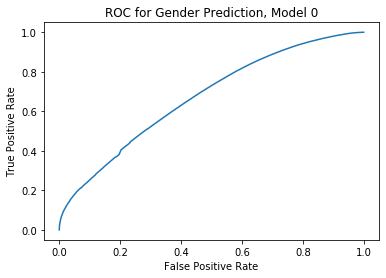

gender precision: 0.477754372897925
gender recall: 0.12484376282969464
gender precision-recall AUC: 0.3025966679636096


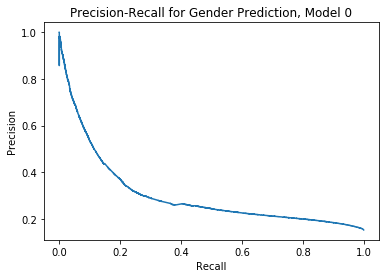

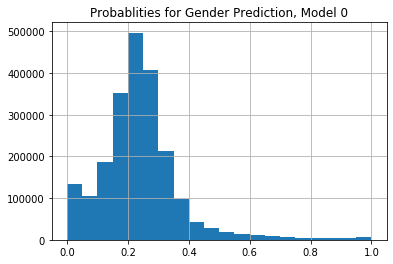

Proportion of predictions for W class: 0.053281975199735356
Copying file://test_to_save2.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/32.2 MiB.                                     
gender ROC_AUC: 0.6230899340190407


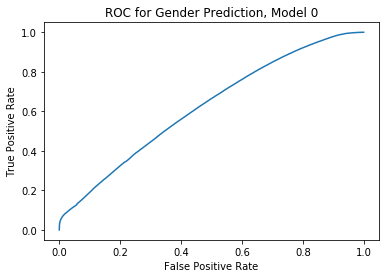

gender precision: 0.3238558863647053
gender recall: 0.1115778983232121
gender precision-recall AUC: 0.25904396974635757


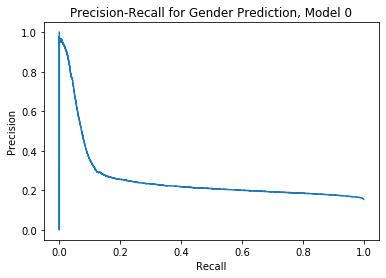

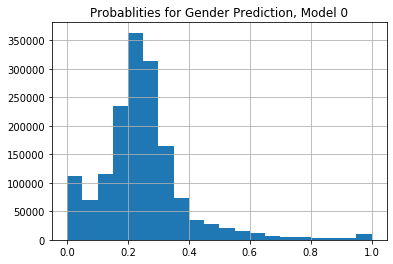

In [8]:
# timestamp is shared across all runs
timestamp = time.time()

for i, hyp_dict in enumerate(hyp_combos):
  print("Training Model {}".format(i))
  new_train_df = remove_excess_rows_per_post(train_df, hyp_dict['MAX_RESPONSES_PER_POST'])
  print("Limiting to {} responses per post resulted in {} training rows".format(hyp_dict['MAX_RESPONSES_PER_POST'],new_train_df.shape[0]))
  if hyp_dict['REMOVE_SHORT_RESP_LENGTH'] > 0:
    new_train_df = remove_short_responses(new_train_df,hyp_dict['REMOVE_SHORT_RESP_LENGTH'])
    dev_df =remove_short_responses(dev_df,hyp_dict['REMOVE_SHORT_RESP_LENGTH'])
    print("Removing responses under {} words resulted in {} training rows".format((hyp_dict['REMOVE_SHORT_RESP_LENGTH']+1),new_train_df.shape[0]))
    ######### Add if using test data###########
    test_df = remove_short_responses(test_df,hyp_dict['REMOVE_SHORT_RESP_LENGTH'])
    ###########################################
  if hyp_dict['SAMPLE_FROM_BEG_AND_END']:
    length = hyp_dict['MAX_SEQUENCE_LENGTH']
    new_train_df = get_beg_end_responses(new_train_df,length)
    dev_df = get_beg_end_responses(dev_df,length)
    ######### Add if using test data###########
    test_df = get_beg_end_responses(test_df,length)
    ###########################################
    print("Responses include only the first {} and last {} words".format((length//2+length%2),length//2))
  else:
    print("Responses include only the first {} words".format(hyp_dict['MAX_SEQUENCE_LENGTH']))

  new_train_df = new_train_df.sample(frac=1)
  dev_df = dev_df.sample(frac=1)
  test_df = test_df.sample(frac=1)


  party_train_df = new_train_df[new_train_df.op_category!='Congress_Independent']
  party_dev_df = dev_df[dev_df.op_category!='Congress_Independent']
  party_test_df = test_df[test_df.op_category!='Congress_Independent']


  # get two sets of labels: gender and party
  print("Getting labels")
  y_train_gender, y_dev_gender, y_test_gender = get_labels(new_train_df, dev_df, test_df, False)
  y_train_party, y_dev_party, y_test_party = get_labels(party_train_df, party_dev_df, party_test_df, True)

  print("Getting inputs")
  X_train, X_dev, X_test, X_train_party, X_dev_party, X_test_party, tokenizer = get_inputs(new_train_df, 
                                                                       dev_df, 
                                                                       test_df,
                                                                       party_train_df,
                                                                       party_dev_df,
                                                                       party_test_df,
                                                                       hyp_dict['N_MOST_FREQ_WORDS_TO_KEEP'], 
                                                                       hyp_dict['MAX_SEQUENCE_LENGTH'])
  embedding_matrix = create_embedding_matrix(
                     '/tmp/glove.6B.{}d.txt'.format(hyp_dict['EMBEDDING_DIM']),
                      tokenizer.word_index, hyp_dict['EMBEDDING_DIM'])
#########################  
  # gender model
  model = make_model(embedding_matrix, 
                     hyp_dict)
  print(model.summary())
  trained_model = train_model(model,
                              X_train,
                              X_dev,
                              y_train_gender,
                              y_dev_gender,
                              hyp_dict['NUM_EPOCHS'],
                              hyp_dict['BATCH_SIZE']
                              )
  
  # adding epoch time just in case we accidentally re-use the same prefixes 
  gender_model_path = '{}_model_{}_gender_{}.h5'.format(MODEL_PREFIX, i, timestamp)
  model.save(gender_model_path)
  !gsutil cp /content/{gender_model_path} gs://fb-congressional-data/models/{gender_model_path}

# Dev set predictions and results.
  preds_dev = model.predict(X_dev)
  dev_df['probs'] = preds_dev
  dev_df['preds'] = dev_df.apply(pred_to_label, axis=1)

  if 'W' in dev_df.preds.value_counts():
    proportion_women_predicted = dev_df.preds.value_counts()['W'] / len(dev_df)
  else:
    proportion_women_predicted = 0
  print("Proportion of predictions for W class: {}".format(proportion_women_predicted))
  dev_to_save = dev_df[['original_idx','probs','preds']]
  dev_to_save.to_csv('dev_to_save2.csv', header=True, index=False)
  !gsutil cp dev_to_save2.csv gs://fb-congressional-data/models/dev_preds.csv

  #ROC-AUC
  fpr,tpr,thresholds = roc_curve(y_dev_gender,preds_dev)
  print("gender ROC_AUC:",roc_auc_score(y_dev_gender,preds_dev))
  plt.plot(fpr,tpr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC for Gender Prediction, Model {}'.format(i))
  plt.show()

  # precision-recall
  print("gender precision:",precision_score(y_dev_gender,preds_dev.round()))
  print("gender recall:",recall_score(y_dev_gender,preds_dev.round()))
  precision, recall, thresholds = precision_recall_curve(y_dev_gender,preds_dev)
  print("gender precision-recall AUC:",auc(recall,precision))
  plt.plot(recall,precision)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall for Gender Prediction, Model {}'.format(i))
  plt.show()

  # Plot probabilities.
  plt.figure()
  plt.title('Probablities for Gender Prediction, Model {}'.format(i))
  dev_df.probs.hist(bins=20)
  plt.show()

# Test set predictions and results.
  preds_test = model.predict(X_test)
  test_df['probs'] = preds_test
  test_df['preds'] = test_df.apply(pred_to_label, axis=1)

  if 'W' in test_df.preds.value_counts():
    proportion_women_predicted = test_df.preds.value_counts()['W'] / len(test_df)
  else:
    proportion_women_predicted = 0
  print("Proportion of predictions for W class: {}".format(proportion_women_predicted))
  test_to_save = test_df[['original_idx','probs','preds']]
  test_to_save.to_csv('test_to_save2.csv', header=True, index=False)
  !gsutil cp test_to_save2.csv gs://fb-congressional-data/models/test_preds.csv

  #ROC-AUC
  fpr,tpr,thresholds = roc_curve(y_test_gender,preds_test)
  print("gender ROC_AUC:",roc_auc_score(y_test_gender,preds_test))
  plt.plot(fpr,tpr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC for Gender Prediction, Model {}'.format(i))
  plt.show()

  # precision-recall
  print("gender precision:",precision_score(y_test_gender,preds_test.round()))
  print("gender recall:",recall_score(y_test_gender,preds_test.round()))
  precision, recall, thresholds = precision_recall_curve(y_test_gender,preds_test)
  print("gender precision-recall AUC:",auc(recall,precision))
  plt.plot(recall,precision)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall for Gender Prediction, Model {}'.format(i))
  plt.show()

  # Plot probabilities.
  plt.figure()
  plt.title('Probablities for Gender Prediction, Model {}'.format(i))
  test_df.probs.hist(bins=20)
  plt.show()

######################################
  # # party model
  # model2 = make_model(embedding_matrix, 
  #                     hyp_dict)
  # trained_model2 = train_model(model2,
  #                              X_train_party,
  #                              X_test_party,
  #                              y_train_party,
  #                              y_dev_party,
  #                              hyp_dict['NUM_EPOCHS'],
  #                              hyp_dict['BATCH_SIZE'])
  
  # party_model_path = '{}_model_{}_party_{}.h5'.format(MODEL_PREFIX, i, timestamp)
  # model2.save(party_model_path)
  # !gsutil cp /content/{party_model_path} gs://fb-congressional-data/models/{party_model_path}

  # preds2 = model2.predict(X_test)
  # dev_df['probs2'] = preds2
  # dev_df['preds2'] = dev_df.apply(pred_to_party_label, axis=1)

  # if 'Congress_Democrat' in dev_df.preds2.value_counts():
  #   proportion_dem_predicted = dev_df.preds2.value_counts()['Congress_Democrat'] / len(dev_df)
  # else:
  #   proportion_dem_predicted = 0
  # print("Proportion of predictions for Democrat class: {}".format(proportion_dem_predicted))

  # #ROC-AUC
  # fpr,tpr,thresholds = roc_curve(y_dev_party,preds2)
  # print("party ROC_AUC:",roc_auc_score(y_dev_party,preds2))
  # plt.plot(fpr,tpr)
  # plt.xlabel('False Positive Rate')
  # plt.ylabel('True Positive Rate')
  # plt.title('ROC for Party Prediction, Model {}'.format(i))
  # plt.show()

  # # precision-recall
  # print("party precision:",precision_score(y_dev_party,preds2.round()))
  # print("party recall:",recall_score(y_dev_party,preds2.round()))
  # precision, recall, thresholds = precision_recall_curve(y_dev_party,preds2)
  # print("party precision-recall AUC:",auc(recall,precision))
  # plt.plot(recall,precision)
  # plt.xlabel('Recall')
  # plt.ylabel('Precision')
  # plt.title('Precision-Recall for Party Prediction, Model {}'.format(i))
  # plt.show()

  # # Plot probabilities.
  # plt.figure()
  # plt.title('Probablities for Party Prediction, Model {}'.format(i))
  # dev_df.probs2.hist(bins=20)
  # plt.show()

In [9]:
preds_dev_check = pd.read_csv("gs://fb-congressional-data/models/dev_preds.csv", index_col=0)
preds_dev_check.head()


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,probs,preds
original_idx,,
2210805,0.288363,M
10316428,0.253759,M
5297343,0.252464,M
5030266,0.293893,M
4918178,0.176300,M


In [10]:
preds_test_check = pd.read_csv("gs://fb-congressional-data/models/test_preds.csv", index_col=0)
preds_test_check.head()


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,probs,preds
original_idx,,
9225551,0.398534,M
7514285,0.363646,M
6128273,0.283775,M
6370382,0.320124,M
8962461,0.316799,M
